<div align="center">
  *PHAS2130*  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    *SN: 15001231*
</div>

## The Infinite 'Unsquare' Well: Solving the 1D Schrödinger Equation using Numerical Methods


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Contents
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1. Introduction
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2. Infinite Square Well
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3. Quantum Harmonic Oscillator
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4. 'Finite' Square Well
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 5. The Double Well
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 6. Discussion
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 6. Bibliography


# 1. Introduction

In quantum mechanics, every measurable observable of a system is associated with an operator, which acts on the system's wavefunction $\psi$ to return an eigenvalue of the observable being measured [1]. In this notebook, we'll use the energy operator, $Ĥ$, to calculate the allowed energy states of various systems based on the 'infinite square well'.

To do this, we need to solve the eigenvalue equation of $Ĥ$ operating on $\psi$, the one-dimensional time-independent Schrödinger equation (TISE):

$$
Ĥ\psi(x) = E\psi(x)
$$

Which can be expanded into the form:

$$
-\frac{\hbar^2}{2m} \frac{d^2\psi}{dx^2} + V(x)\psi(x) = E\psi(x)
$$

Where $\hbar$ is the reduced Planck constant, $m$ is the particle mass and $V(x)$ is the system's potential as a function of x. This is a second order ordinary differential equation in $\psi$, which can be solved using a variety of different numerical methods.

#### 1.1 Runge-Kutta Method

In order to solve the TISE, we need to split the equation into two first order differential equations:

$$
\frac{d \psi}{dx } = \phi, \\
\frac{d \phi}{dx } = \frac{2m}{\hbar^2} \left[V(x) - E \right] \psi(x),
$$

We can solve each of these in turn using an iterative technique known as the *Runge-Kutta* method. This works by calculating four different estimates for the change in derivative of $\psi$ over a certain designated interval, then taking a weighted average of the estimates to calculate the value of $\psi$ one interval later [2].

#### 1.2 Secant Method

Only certain wavefunctions can physically exist for a given system, however, so we need to find a way to incorporate the *boundary conditions* of the system into our numerical method - in this case that $\psi(x)=0$ when $V(x)=\infty$. We do this using the *secant method*, a technique that uses iterations of secant lines to calculate the roots (i.e. zeroes) of a function.

![](https://www.cs.purdue.edu/homes/dgleich/cs514-2016/julia/tmp.gif?0.5108956892188807%3E)

#### *Fig.1. Animation of the secant method finding a root of a function.*

Source: https://www.cs.purdue.edu/homes/dgleich/cs514-2016/julia/Lecture-24-Secant-convergence.html

Combining these two methods allows us to numerically solve the TISE for any given infinite square well-like system (i.e. any system where the particle is bound between two points on the x-axis). In this notebook, we use this technique to evaluate the eigenvalues and eigenstates of four different systems: the infinite square well, finite square well, quantum harmonic oscillator and the double well. 

# 2. Infinite square well

The simplest system we can analyse is the infinite square well (ISW), where a particle is bound between two regions of infinite potential at $x=±a$:
 
![](https://upload.wikimedia.org/wikipedia/commons/a/a2/Infinite_potential_well_2.PNG)
##### ** Fig.2. The infinite square well**
Source: https://commons.wikimedia.org/wiki/File:Infinite_potential_well_2.PNG

To model this potential, we'll define a function `V(x)` that returns a value of `0.0` for all values of x. As we're only going to be inputting x-values between $-a$ and $a$, this function creates the flat-bottomed curve that we need.

#### 2.1 Potential function

In [1]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-notebook')

#Potential function:

def V(x):
    '''Calculates the infinite square well potential from input x (position)'''
    return 0.0   #infinite square well

#### 2.2 Defining the Schrödinger Equation

Now we need to define the parameters of our well. We'll use an electron in a well of width $1 Å $ $(0.1 nm)$ (the approximate diameter of the hydrogen atom), a size that will allow us to clearly visualise how the wavefunction behaves at the atomic scale.

In [2]:
m = 9.1094 * 10**(-31) # electron mass
h_bar = 1.0546 * 10**(-34)  #reduced planck constant
e = 1.6022 * 10**(-19) #elecron charge
a = 5 * 10**(-11)  #well half width

Defining a function for the solutions of the TISE is easiest with three input variables: 

`r`, a vector containing the values of $\psi$ and $\phi$ in the form `r = [psi,phi]`.

`x`, the position along the x-axis.

`E`, the energy of the particle.

In [3]:
def f(r,x,E): 
    '''Schrödinger equation for a particle in a potential V.
    Inputs are r (phi and psi), x (position), and E'''
    psi = r[0]  #first element of r is psi
    phi = r[1] #second element of r is psi
    fpsi = phi  #derivative of psi = phi
    fphi = 2*m*(h_bar**(-2))*(V(x)-E)*psi #derivative of phi = rhs of schrödinger eqn
    return np.array([fpsi,fphi]) #return fpsi and fphi as array

#### 2.3 Defining the Runge-Kutta function

Before we write our Runge-Kutta function, we need to define the parameters that the function will use. We need to tell the function the range of values to iterate over (`xstart` and `xend`) and the size of each iteration interval, `h`:

In [4]:
xstart = -a          # start position,
xend = a           # end position, in m.
N = 1000              # number of points for Runge-Kutta
h = (xend - xstart)/N # size of Runge-Kutta steps

xpoints = np.arange(xstart, xend, h) #define x-array

One caveat we need to be aware of when defining the Runge-Kutta function is that the `xpoints` array spans from $-a$ to $a-h$, meaning that we need additional terms in order to calculate the value of the function at $x=a$. This is essential, as we need the value of $\psi(a)$ to make sure our solutions match the boundary conditions.

In [5]:
def RungeKutta2d(E):
    '''Solves Schrödinger equation using 4th order Runge-Kutta method
    Input: E - the energy (eigenvalue) of the particular state that we want to find psi for
    Outputs: [psi] - array of (unnormalised) wavefunction values from xstart to xend'''
    
    phi = [1.0] # initialise empty arrays
    psi = [0.0]
    r = np.array([psi,phi])
    
    for x in xpoints: # loops over all xpoints up to (xend-h)
        
        #Runge-Kutta eqns:
        
        k1 = h*f(r,x,E) 
        k2 = h*f(r+0.5*k1, x+0.5*h, E) 
        k3 = h*f(r+0.5*k2, x+0.5*h, E)
        k4 = h*f(r+k3, x+h, E)
        r = r + (k1 + 2*k2 + 2*k3 + k4)/6
        
        psi.append(r[0])
        phi.append(r[1])
        
        
    # Calculate value at endpoint:
    psi.append(r[0])
    phi.append(r[1])

    return np.array([psi,phi])[0] #produce array of psi and phi, taking only psi 

The function `RungeKutta2d` takes the energy of the state we want to analyse and calculates the corresponding array of $\psi$ values from $-a$ to $a$. However, in order to pass values of `E` to this function, we first need to find the system's allowed values of `E`. We do this using a combination of the Runge Kutta function and the secant method.


#### 2.4 The Secant Method



In order to find the allowed energies of a system, we need to look at the system's *boundary conditions*. In the case of the infinite square well this is relatively simple: as the potential in the region at and beyond $\pm a$ is infinite, the wavefunction (and therefore the probability of finding the particle) at $\pm a$ must be 0.

The secant method takes two initial guesses for the energy, `E1` and `E2`, and calculates the values of $\psi(a)$ for each. It then recalculates `E1` and `E2` by taking secant lines through the curve of $\psi(x)$ (see Fig.1.), a process which could be repeated infinitely many times such that the difference between `E1` and `E2` is zero. As we can't use an infinite number of iterations, we introduce the variable `tolerance`, a number many orders of magnitude smaller than `E1` or `E2` that we can use to terminate the function. The process will continue finding more and more accurate values of energy until the difference between the calculated energies is less than `tolerance`, at which point it will print the calculated energy, `E2`.

The code cell below demonstrates the process for finding the lowest energy state; the two initial guesses are $0$ $eV$ and $45$ $eV$, calculating a ground state energy of $37.6$ $eV$ (see the next section for further analysis).

In [6]:
#Initial energy guesses:
E1 = 0
E2 = 45*e

psi2 = RungeKutta2d(E1)[-1] #define psi2 as the last value of the output from RungeKutta2d(E1)

tolerance = e/1000  #define the precision of our method 

while abs(E1-E2)>tolerance:    #the loop will run whilst the difference between E1 and E2 is greater than e/1000
    psi1 = psi2  
    psi2 = RungeKutta2d(E2)[-1]
    E1, E2 = E2, E2-psi2*(E2-E1)*np.power((psi2-psi1),-1)


print("Energy for n=1: ",E2,"J"," [",E2/e, "eV ]") #print energy

Energy for n=1:  6.02497851124e-18 J  [ 37.604409632 eV ]


#### 2.5 Normalisation and the first four states

Now that we've calculated an energy and it's associated wavefunction, we need to normalise the wavefunction such that the total probability of finding the particle in the well is 1 (i.e. $\int | \psi(x) |^2 {\rm d} x = 1$). We do this by defining a new function, `psi_normalised`, that uses the trapezium rule to find the area under the curve of $| \psi(x) |^2$, then divides each value of $\psi(x)$ by the square root of this area. This produces a new array of normalised $\psi$ values.

In [7]:
xarray = np.linspace(-5 * 10**(-11), 5 * 10**(-11), 1002) #create array of x-values from -a to a

def psi_normalised(E):
    '''
    Normalises wavefunction
    Input: Energy (i.e. eigenvalue)
    Output: array of normalised psi values for that particular energy'''
    area = np.trapz(RungeKutta2d(E)**2, xarray, dx=h, axis=0)   #integral using trapezium rule
    psinorm = RungeKutta2d(E)*np.power(area,-0.5)  #rescale psi such that the wavefunction is normalised
    return psinorm

As the infinite square well has analytic solutions, we can compare our numerical results with the known wavefunctions and eigenvalues. The eigenenergies of the well are given by:
$$
E_n = \frac{\pi^2 \hbar^2 n^2}{2m (2a)^2}
$$

where $n$ is the principal quantum number and $a$ is the half width of the well.

The wavefunction depends on the parity of $n$:

$$
\psi_n(x)  = \frac{1}{\sqrt{a}} \cos\left(\frac{ n \pi x}{2a}\right) \qquad 
    n \ \mathrm{odd}
    $$
    $$
    \psi_n(x)  = \frac{1}{\sqrt{a}} \sin\left(\frac{ n \pi x}{2a}\right) \qquad
    n \ \mathrm{even}.
$$

These three equations are represented by the functions `psi_odd`, `psi_even` and `true_energy` in the code cell below.

In [8]:
def psi_odd(n,x):
    '''Returns normalised wavefunction for odd values of n.
    takes:  n (primary quantum number)
            x (x value)'''
    return np.cos(n*x*np.pi/(2*a))*(a**-0.5)

def psi_even(n,x):
    '''Returns normalised wavefunction for even values of n.
    takes:  n (primary quantum number)
            x (x value)'''
    return np.sin(n*x*np.pi/(2*a))*(a**-0.5)

def true_energy(n):
    '''Takes primary quantum number, n, and returns the analytic energy of the state'''
    return ((np.pi*h_bar*n)**2)/(8*m*(a**2))

We can now plot the calculated ground state wavefunction, along with the analytic solution. Throughout the rest of the notebook, $\psi(x)$ will be in red and the potential, $V(x)$, will be in blue.

Energy for n=1:  6.02497851124e-18 J  [ 37.604409632 eV ]
Expected energy for n=1:  6.024978632810429e-18 J  [ 37.60441039077786 eV ]


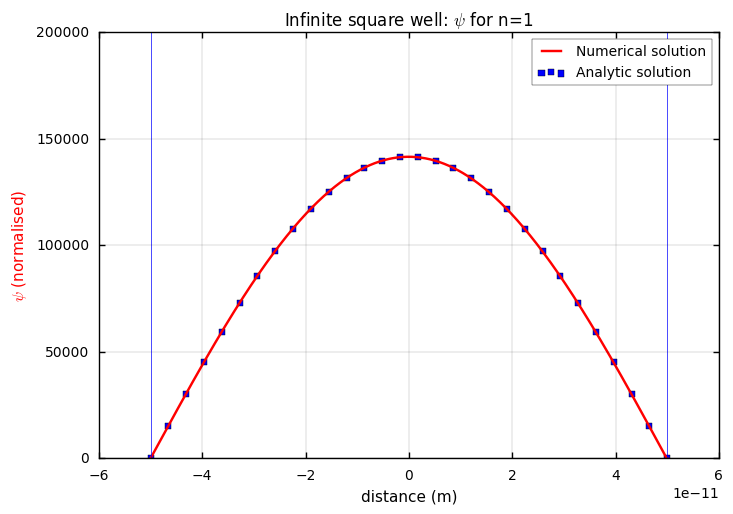

In [9]:
#PLOTTING
plt.plot(xarray, psi_normalised(E2),'r', label='Numerical solution') #calculated psi
plt.scatter(np.linspace(-a,a,30), psi_odd(1,np.linspace(-a,a,30)), marker = 's', label = 'Analytic solution') #actual psi
plt.axvline(x=-a,ymin=0, c='b',ls='-',lw=0.5) #x=-a line
plt.axvline(x=a,ymin=0, c='b',ls='-',lw=0.5) #x=a line
plt.ylim(0,200000)
plt.grid(linewidth=0.1, linestyle='-') #gridlines
plt.title("Infinite square well: $\psi$ for n=1")
plt.ylabel('$\psi$ (normalised)', color='r')
plt.xlabel('distance (m)')
plt.legend()


print("Energy for n=1: ",E2,"J"," [",E2/e, "eV ]")
print("Expected energy for n=1: ",true_energy(1),"J"," [",true_energy(1)/e, "eV ]")
eigenenergy1 = E2

Comparing the the energies and wavefunctions of the ground state, we find excellent agreement between the numerical and analytic solutions. 

Now we'll repeat this process to find the next three states of the infinite potential well. Finding appropriate values for `E1` and `E2` requires some degree of guesswork, but by considering that $E_n \propto\ n^2$ we can estimate suitable values without too much difficulty.

#### n = 2

Energy for n=2:  2.40999145446e-17 J  [ 150.417641647 eV ]
Expected energy for n=2:  2.4099914531241717e-17 J  [ 150.41764156311143 eV ]


''

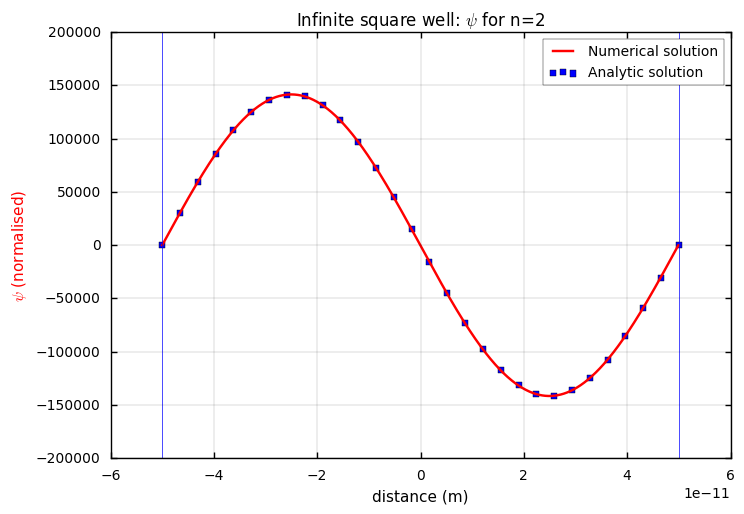

In [10]:
#SECANT METHOD:
E1 = 45*e
E2 = 160*e
psi2 = RungeKutta2d(E1)[-1]

tolerance = e/1000

while abs(E1-E2)>tolerance:
    psi1 = psi2
    psi2 = RungeKutta2d(E2)[-1]
    E1, E2 = E2, E2-psi2*(E2-E1)*np.power((psi2-psi1),-1)
        
print("Energy for n=2: ",E2,"J"," [",E2/e, "eV ]")
print("Expected energy for n=2: ",true_energy(2),"J"," [",true_energy(2)/e, "eV ]")
eigenenergy2 = E2

#PLOTTING
plt.plot(xarray, psi_normalised(E2),'r', label='Numerical solution') #calculated psi
plt.scatter(np.linspace(-a,a,30),psi_even(2,(np.linspace(-a,a,30)-a)), marker = 's', label = 'Analytic solution') #actual psi
plt.axvline(x=-a,ymin=0,c='b',ls='-',lw=0.5)
plt.axvline(x=a,ymin=0, c='b',ls='-',lw=0.5)
plt.grid(linewidth=0.1, linestyle='-')
plt.title("Infinite square well: $\psi$ for n=2")
plt.ylabel('$\psi$ (normalised)', color='r')
plt.xlabel('distance (m)')
plt.legend()
;

#### n = 3

Energy for n=3:  5.42248077024e-17 J  [ 338.439693561 eV ]
Expected energy for n=3:  5.4224807695293863e-17 J  [ 338.43969351700076 eV ]


''

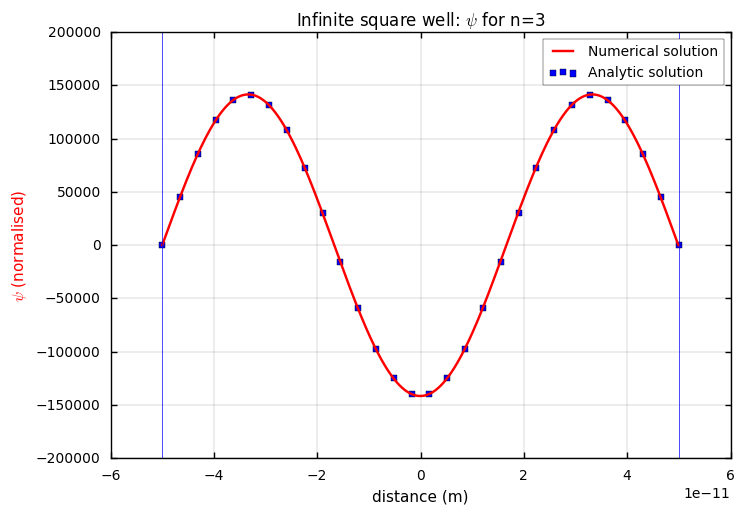

In [11]:
#SECANT METHOD:
E1 = 160*e
E2 = 310*e
psi2 = RungeKutta2d(E1)[-1]

tolerance = e/1000

while abs(E1-E2)>tolerance:
    psi1 = psi2
    psi2 = RungeKutta2d(E2)[-1]
    E1, E2 = E2, E2-psi2*(E2-E1)*np.power((psi2-psi1),-1)
        
print("Energy for n=3: ",E2,"J"," [",E2/e, "eV ]")
print("Expected energy for n=3: ",true_energy(3),"J"," [",true_energy(3)/e, "eV ]")
eigenenergy3 = E2

#PLOTTING:
plt.plot(xarray, (psi_normalised(E2)),'r', label='Numerical solution')
plt.scatter(np.linspace(-a,a,30), psi_odd(3,np.linspace(-a,a,30)-(2/3)*a), marker = 's', label = 'Analytic solution')
plt.axvline(x=-a,c='b',ls='-',lw=0.5)
plt.axvline(x=a, c='b',ls='-',lw=0.5)
plt.grid(linewidth=0.1, linestyle='-')
plt.title("Infinite square well: $\psi$ for n=3")
plt.ylabel('$\psi$ (normalised)', color='r')
plt.xlabel('distance (m)')
plt.legend()
;

#### n = 4

Energy for n=4:  9.63996581626e-17 J  [ 601.670566487 eV ]
Expected energy for n=4:  9.639965812496687e-17 J  [ 601.6705662524457 eV ]


''

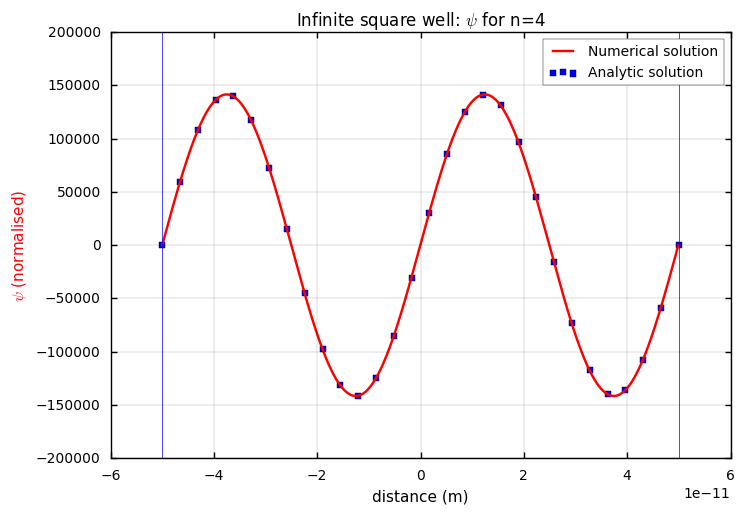

In [12]:
#SECANT METHOD:
E1 = 300*e
E2 = 610*e
psi2 = RungeKutta2d(E1)[-1]

tolerance = e/1000

while abs(E1-E2)>tolerance:
    psi1 = psi2
    psi2 = RungeKutta2d(E2)[-1]
    E1, E2 = E2, E2-psi2*(E2-E1)*np.power((psi2-psi1),-1)
        
print("Energy for n=4: ",E2,"J"," [",E2/e, "eV ]")
print("Expected energy for n=4: ",true_energy(4),"J"," [",true_energy(4)/e, "eV ]")
eigenenergy4 = E2

#PLOTTING:
plt.plot(xarray, (psi_normalised(E2)),'r', label='Numerical solution')
plt.scatter(np.linspace(-a,a,30), psi_even(4,np.linspace(-a,a,30)), marker = 's', label = 'Analytic solution')
plt.axvline(x=-a,c='b',ls='-',lw=0.5)
plt.axvline(x=a, c='b',ls='-',lw=0.5)
plt.grid(linewidth=0.1, linestyle='-')
plt.title("Infinite square well: $\psi$ for n=4")
plt.ylabel('$\psi$ (normalised)', color='r')
plt.xlabel('distance (m)')
plt.legend()
;

The above plots of the first four energy states clearly illustrate the familiar sinusoidal nature of the square well wavefunction. The number of nodes for each wavefunction is given by $n+1$, analogous to the nodes of a vibrating fixed string (where $n$ gives the number of each harmonic). Note that for $n=2$ and $n=3$, a respective phase shift of $+a$ and $+\frac{2}{3}a$ has been added to the analytic solution. This phase shift doesn't affect the (analytic) probability density, $|\psi(x) |^2$, but shifts the analytic wavefunction such that it matches the numerically evaluated curve.

The diagramatic representation of these first four energy levels below allows us to see how energy varies quadratically with $n$:

''

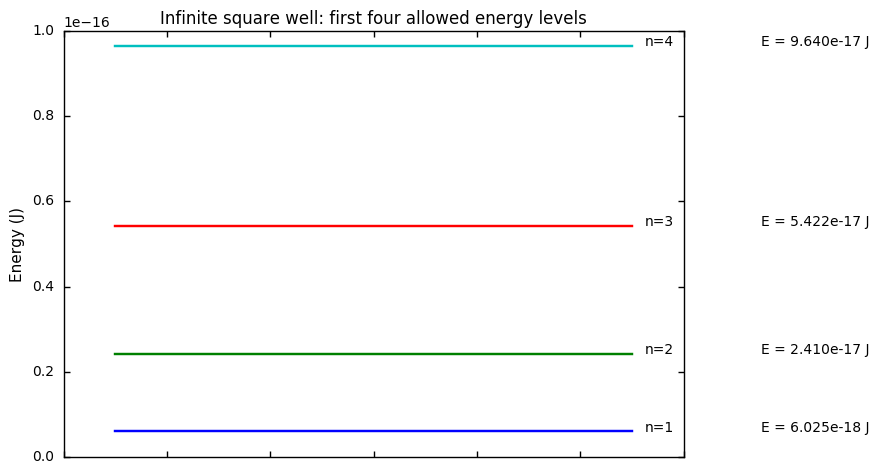

In [13]:
fig, ax1 = plt.subplots()

#PLOT LINES:
ax1.plot(xarray, (xarray*0)+eigenenergy1) #n=1
ax1.plot(xarray, (xarray*0)+eigenenergy2)#n=2
ax1.plot(xarray, (xarray*0)+eigenenergy3)#n=3
ax1.plot(xarray, (xarray*0)+eigenenergy4)#n=4

#LABELS:
ax1.text(1.05*a,eigenenergy1,'n=1')
ax1.text(1.05*a,eigenenergy2,'n=2')
ax1.text(1.05*a,eigenenergy3,'n=3')
ax1.text(1.05*a,eigenenergy4,'n=4')
ax1.text(1.5*a,eigenenergy1,'E = 6.025e-18 J')
ax1.text(1.5*a,eigenenergy2,'E = 2.410e-17 J')
ax1.text(1.5*a,eigenenergy3,'E = 5.422e-17 J')
ax1.text(1.5*a,eigenenergy4,'E = 9.640e-17 J')
plt.title("Infinite square well: first four allowed energy levels")
ax1.set_xticklabels([]) #remove x axis numbers
ax1.set_ylabel('Energy (J)')
;

#### 2.6 Higher energies: n = 20

Our method can also be used to evaluate the eigenenergies and wavefunctions of higher energy states. For example, we can estimate the energy for the $n=20$ state by observing that the energy of each level $n$ is $E_n = E_{1}n^2$, so the energy of the twentieth state will be roughly $E_{20} \approx 37(20^2) = 14800 eV$. Choosing two guesses on either side of this value, $14000$ $eV$ and $15000$ $eV$, produces the desired wavefunction below.

Energy for n=20:  2.40999207826e-15 J  [ 15041.768058 eV ]
Expected energy for n=20:  2.4099914531241717e-15 J  [ 15041.764156311145 eV ]


''

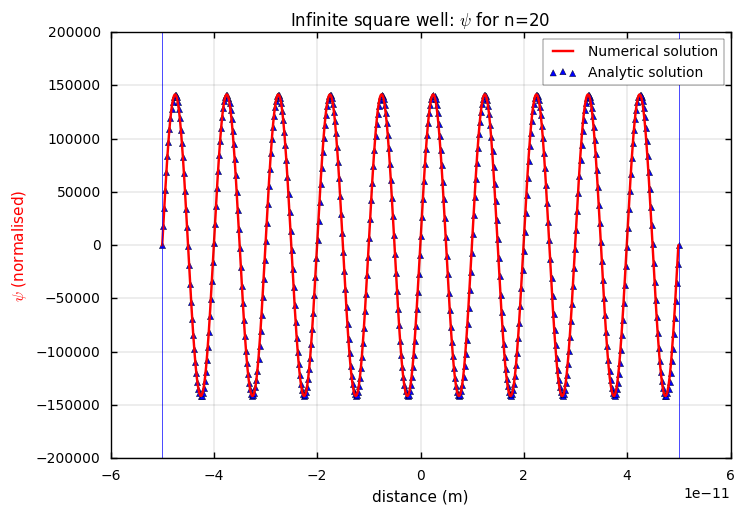

In [14]:
#SECANT METHOD:
E1 = 14000*e
E2 = 16000*e
psi2 = RungeKutta2d(E1)[-1]

tolerance = e/1000

while abs(E1-E2)>tolerance:
    psi1 = psi2
    psi2 = RungeKutta2d(E2)[-1]
    E1, E2 = E2, E2-psi2*(E2-E1)*np.power((psi2-psi1),-1)
        
print("Energy for n=20: ",E2,"J"," [",E2/e, "eV ]")
print("Expected energy for n=20: ",true_energy(20),"J"," [",true_energy(20)/e, "eV ]")

#PLOTTING:
plt.plot(xarray, (psi_normalised(E2)),'r', label='Numerical solution')
plt.scatter(np.linspace(-a,a,500), psi_even(20,np.linspace(-a,a,500)), marker = '^', label = 'Analytic solution')
plt.axvline(x=-a,c='b',ls='-',lw=0.5)
plt.axvline(x=a, c='b',ls='-',lw=0.5)
plt.grid(linewidth=0.1, linestyle='-')
plt.title("Infinite square well: $\psi$ for n=20")
plt.ylabel('$\psi$ (normalised)', color='r')
plt.xlabel('distance (m)')
plt.legend()
;

Note that the wavelength of $\psi$ varies with $n$ as:
$$
\lambda = \frac{4a}{n}
$$

Which can be substituted into the De Broglie equation $p = \frac{h}{\lambda }$ to give an expression for electron momentum: 

$$
p = \frac{nh}{4a}
$$

As the electron can either be moving from left to right or vice-versa with equal probability, the uncertainty in its momentum can be approximated as $\sigma_p = \frac{nh}{4a} = \frac{n \hbar \pi}{2a}$, and the uncertainty in position can be approximated as $\sigma_x = 2a$. 

Taking the product of these two quantities we find that $\sigma_p \sigma_x = n \hbar \pi$, consistent with the Heisenberg uncertainty principle that $\sigma_p \sigma_x  \geq \frac{\hbar}{2}$

## 3. Quantum Harmonic Oscillator

Potentials of the form $V(x) \propto x^2$ are known as *harmonic potentials*. Computationally, solving the Schrödinger equation for a particle in such a potential would be impossible using our method, as the function has no asymptotes (i.e. the function only becomes infinite at $x=\pm \infty$), making it impossible to use the secant method to evaluate the boundary conditions and find the roots of the wavefunction as we did previously.

Instead, we approximate the harmonic potential by keeping the 'walls' of the infinite square well and changing the shape of the base of the well:

![](http://i.imgur.com/Y56cQE2.png)

#### *Fig.3. Approximation of the harmonic potential using infinite square walls.*

Source: PHAS2130 Final Assignment

To do this, we change our potential function to the form:
$$
V(x) = V_0 \frac{x^2}{a^2}
$$

where $V_0$ is a variable that determines the 'depth of the potential. Looking at the typical energies involved in the infinite square well, a depth of $V_0 = 800$ $eV$ will be enough model the first few eigenstates.

In [15]:
v0 = 800*e #set v0 to 800eV

def V_harmonic(x):
    '''Calculates the simple harmonic potential from input x (position)'''
    v = v0*(x**2)/(a**2)
    return v

We also need to update the Schrödinger function, `f`, replacing `V(x)` with the newly defined harmonic potential, `V_harmonic(x)`.

In [16]:
def f(r,x,E): 
    '''Schroedinger equation for a particle in a potential V.
    Inputs are r (phi and psi), x (position), and E'''
    psi = r[0]  #first element of r is psi
    phi = r[1] #second element of r is psi
    fpsi = phi  #derivative of psi = phi
    fphi = 2*m*(h_bar**(-2))*(V_harmonic(x)-E)*psi #derivative of phi = rhs of shrödinger eqn
    return np.array([fpsi,fphi]) #return fpsi and fphi as array

#### 3.1 The first three states

The plots below show the wavefunction, $\psi(x)$ along with the harmonic potential for $n=0,1,2$. Note that the grey vertical lines at $x = \pm a$.

#### n=0

Energy for n=0:  1.77619268138e-17 J  [ 110.859610622 eV ]


''

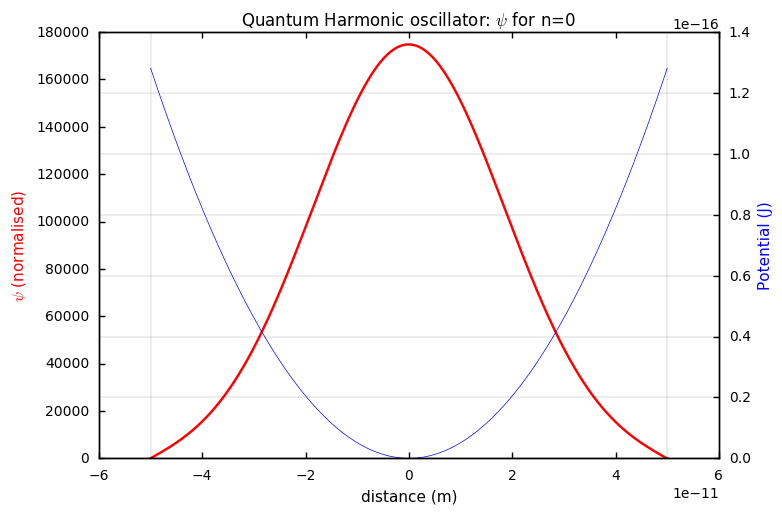

In [17]:
#SECANT METHOD:
E1 = 0.0
E2 = 45*e
psi2 = RungeKutta2d(E1)[-1]

tolerance = e/1000

while abs(E1-E2)>tolerance:
    psi1 = psi2
    psi2 = RungeKutta2d(E2)[-1]
    E1, E2 = E2, E2-psi2*(E2-E1)*np.power((psi2-psi1),-1)
        
print("Energy for n=0: ",E2,"J"," [",E2/e, "eV ]")
qho_1 = E2

psi_qho_normalised_1 = psi_normalised(E2) #normalise psi


#PLOTTING:
fig, ax1 = plt.subplots()

#PSI:
ax1.plot(xarray, psi_qho_normalised_1, 'r')
ax1.set_xlabel('distance (m)')
ax1.set_ylabel('$\psi$ (normalised)', color='r')

#POTENTIAL:
ax2 = ax1.twinx()
ax2.plot(xarray, V_harmonic(xarray), 'b', lw=0.5)
ax2.set_ylabel('Potential (J)', color='b')

plt.axvline(x=-a,c='k',ls='-',lw=0.1)
plt.axvline(x=a, c='k',ls='-',lw=0.1)
plt.grid(linewidth=0.1, linestyle='-')
plt.title("Quantum Harmonic oscillator: $\psi$ for n=0")
;

#### n = 1

Energy for n=1:  5.3931791474e-17 J  [ 336.610856785 eV ]


''

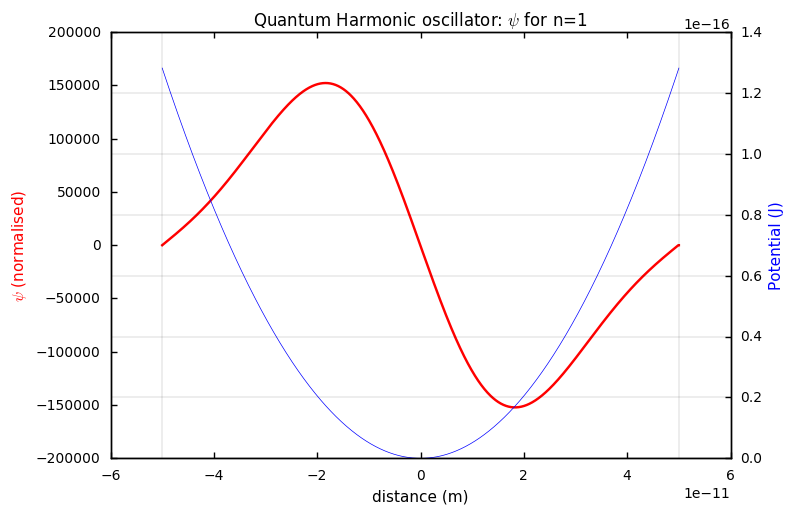

In [18]:
#SECANT METHOD:
E1 = 45*e
E2 = 300*e
psi2 = RungeKutta2d(E1)[-1]

tolerance = e/1000

while abs(E1-E2)>tolerance:
    psi1 = psi2
    psi2 = RungeKutta2d(E2)[-1]
    E1, E2 = E2, E2-psi2*(E2-E1)*np.power((psi2-psi1),-1)
        
print("Energy for n=1: ",E2,"J"," [",E2/e, "eV ]")
qho_2 = E2

psi_qho_normalised_2 = psi_normalised(E2) #normalise psi


#PLOTTING: 
fig, ax1 = plt.subplots()

#PSI:
ax1.plot(xarray, psi_qho_normalised_2, 'r')
ax1.set_xlabel('distance (m)')
ax1.set_ylabel('$\psi$ (normalised)', color='r')

#POTENTIAL
ax2 = ax1.twinx()
ax2.plot(xarray, V_harmonic(xarray), 'b', lw=0.5)
ax2.set_ylabel('Potential (J)', color='b')

plt.axvline(x=-a,c='k',ls='-',lw=0.1)
plt.axvline(x=a, c='k',ls='-',lw=0.1)
plt.grid(linewidth=0.1, linestyle='-')
plt.title("Quantum Harmonic oscillator: $\psi$ for n=1")
;

#### n = 2

Energy for n=2:  9.30041330074e-17 J  [ 580.477674494 eV ]


''

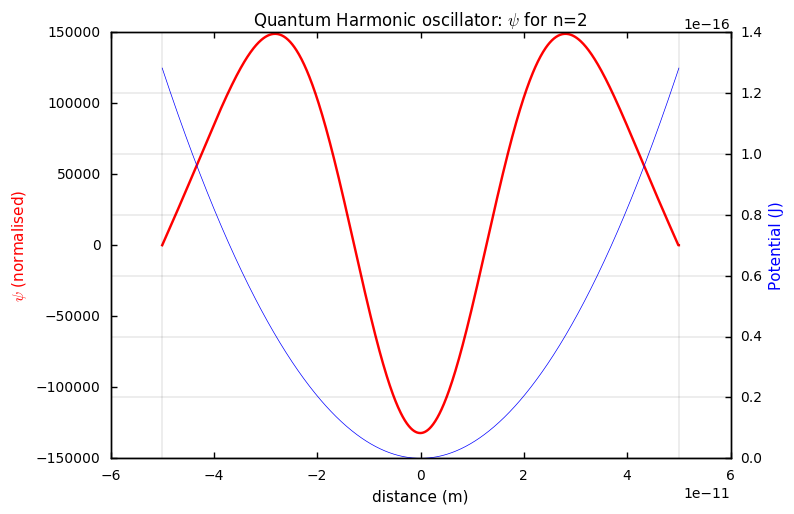

In [19]:
#SECANT METHOD:
E1 = 300*e
E2 = 500*e
psi2 = RungeKutta2d(E1)[-1]

tolerance = e/1000

while abs(E1-E2)>tolerance:
    psi1 = psi2
    psi2 = RungeKutta2d(E2)[-1]
    E1, E2 = E2, E2-psi2*(E2-E1)*np.power((psi2-psi1),-1)
        
print("Energy for n=2: ",E2,"J"," [",E2/e, "eV ]")
qho_3 = E2

psi_qho_normalised_3 = psi_normalised(E2) #normalise psi


#PLOTTING:
fig, ax1 = plt.subplots()

#PSI:
ax1.plot(xarray, psi_qho_normalised_3, 'r')
ax1.set_xlabel('distance (m)')
ax1.set_ylabel('$\psi$ (normalised)', color='r')

#POTENTIAL
ax2 = ax1.twinx()
ax2.plot(xarray, V_harmonic(xarray), 'b', lw=0.5)
ax2.set_ylabel('Potential (J)', color='b')

plt.axvline(x=-a,c='k',ls='-',lw=0.1)
plt.axvline(x=a, c='k',ls='-',lw=0.1)
plt.grid(linewidth=0.1, linestyle='-')
plt.title("Quantum Harmonic oscillator: $\psi$ for n=2")
;

Plotting these wavefunctions and their energies on a single diagram allows us to analyse them further.

''

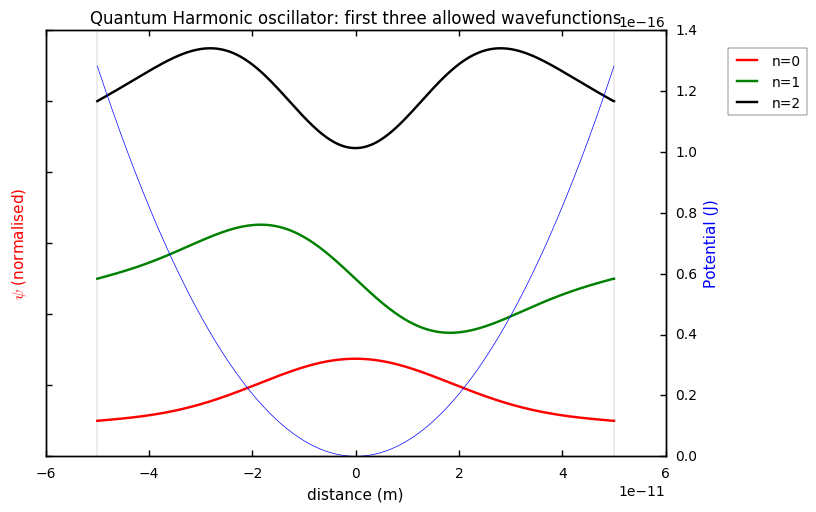

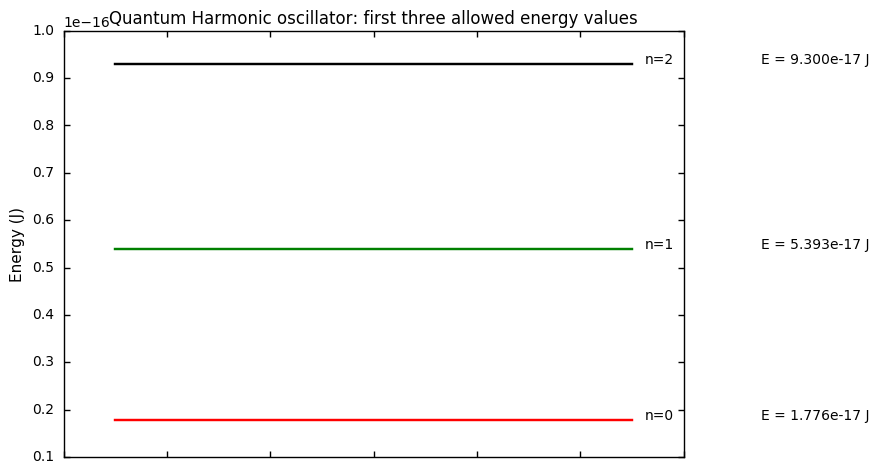

In [20]:
#WAVEFUNCTION PLOT:

fig, ax1 = plt.subplots()

#Psi:
ax1.plot(xarray, psi_qho_normalised_1+100000, 'r', label='n=0') #plot n=0
ax1.plot(xarray, psi_qho_normalised_2+500000, 'g', label='n=1') #plot n=1
ax1.plot(xarray, psi_qho_normalised_3+1000000, 'k', label='n=2') #plot n=2
ax1.set_xlabel('distance (m)')
ax1.legend(loc=[1.1,0.8])
ax1.set_ylabel('$\psi$ (normalised)', color='r')
ax1.set_yticklabels([])
#Potential:
ax2 = ax1.twinx()
ax2.plot(xarray, V_harmonic(xarray), 'b', lw=0.5) #plot potential
ax2.set_ylabel('Potential (J)', color='b')

plt.axvline(x=-a,c='k',ls='-',lw=0.1)
plt.axvline(x=a, c='k',ls='-',lw=0.1)
plt.title("Quantum Harmonic oscillator: first three allowed wavefunctions")

;

#EIGENVALUE PLOT:
fig, ax1 = plt.subplots()

ax1.plot(xarray, (xarray*0)+qho_1, 'r',label='n=0') #plot n=0
ax1.plot(xarray, (xarray*0)+qho_2, 'g',label='n=1') #plot n=1
ax1.plot(xarray, (xarray*0)+qho_3, 'k',label='n=2') #plot n=2
ax1.text(1.05*a,qho_1,'n=0')
ax1.text(1.05*a,qho_2,'n=1')
ax1.text(1.05*a,qho_3,'n=2')
ax1.text(1.5*a,qho_1,'E = 1.776e-17 J')
ax1.text(1.5*a,qho_2,'E = 5.393e-17 J')
ax1.text(1.5*a,qho_3,'E = 9.300e-17 J')

plt.title("Quantum Harmonic oscillator: first three allowed energy values")

ax1.set_xticklabels([])
ax1.set_ylabel('Energy (J)')
;

A number of interesting features can be seen here. From the wavefunction plots, it can be seen that the wavefunction *does not* drop to zero when $V(x) = E_n$, instead decaying exponentially to zero at $x = \pm a$. This agrees with the tunneling found in the analytic solution to the quantum harmonic oscillator, where the wavefunction decays as a factor of $e^{-kx^2}$ ($k$ is a constant). However, one major difference between the actual wavefunctions and the numerical results above is the extent of the tunneling: in reality, $\psi$ drops to zero at $x=\infty$, not $x = \pm a$.

Analytically, the energy of each state is given by $E_n = (n + \frac{1}{2})\hbar \omega$, implying a non-zero eigenvalue for $n=0$ and equal spacing between each energy level. This can be seen in the diagram above, where the ground state (or 'zero point') energy is $E_0 = 110.6$ $eV$ and each subsequent level is equally spaced from the last. However, one way in which these results differ from the analytic solution is the overly-large energy values found through the numerical method. In reality, each energy level would be slightly *lower* than the values found above. This can be understood in terms of the wavelength of $\psi$: the infinite square well walls slightly shorten the wavelength of $\psi$ by introducing the boundary conditions $\psi(\pm a)=0$, whereas the physical wavefunction would actually extend to $\pm \infty$. As the wavelength is slightly shortened, the energy is slightly increased.

## 4. Finite square well

In order to approximate the finite square well (FSW), we keep the infinite square well walls and change the base of the well, just as we did with the harmonic oscillator. To do this, we define a potential function `V_finite(x)` that produces a square wave with period $1.5a$ and amplitude $V_0$, recreating a square well of width $a$ and depth $V_0$ centred on the origin. Like before, we've kept this depth as $800$ $eV$.

$$
V_x = \begin{cases} 0 & \text{if } -a/2 < x < +a/2, \\ 
    V_0  & \text{if } |x| > a/2, \end{cases} 
$$

We then need to update our Schrödinger function, `f`, with our new potential function.

In [21]:
v0 = 800*e #define v0

def V_finite(x):
    '''Calculates the a finite square well potential between -a and a, taking input x (position)'''
    # Uses np.sign and a sine wave to create a square wave with period 1.5a and amplitude v0
    return v0*0.5*(np.sign(np.sin(np.pi*((x/a)+1.5)))+1)

In [22]:
def f(r,x,E): 
    '''Shroedinger equation for a particle in a potential V.
    Inputs are r (phi and psi), x (position), and E'''
    psi = r[0]  #first element of r is psi
    phi = r[1] #second element of r is psi
    fpsi = phi  #derivative of psi = phi
    fphi = 2*m*(h_bar**(-2))*(V_finite(x)-E)*psi #derivative of phi = rhs of schrödinger eqn
    return np.array([fpsi,fphi]) #return fpsi and fphi as array

#### 4.1 The first three states

As the finite square well has no analytic solutions, estimating values of `E1` and `E2` necessarily involves a certain amount of trial and error. Using initial values similar to those in the infinite square well, each value was then fine-tuned until the desired wavefunction was produced. 

#### *n=1*

Energy for n=1:  1.46854444564e-17 J  [ 91.6579981052 eV ]


''

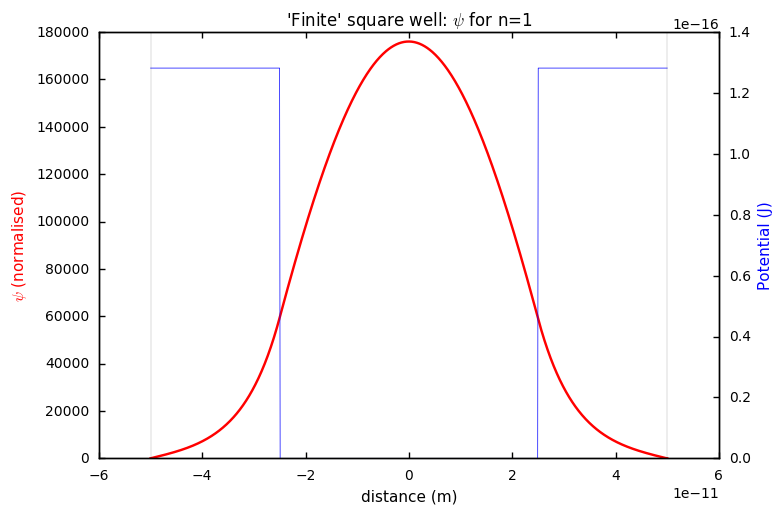

In [23]:
#SECANT METHOD:
E1 = 0.0
E2 = 45*e
psi2 = RungeKutta2d(E1)[-1]

tolerance = e/1000

while abs(E1-E2)>tolerance:
    psi1 = psi2
    psi2 = RungeKutta2d(E2)[-1]
    E1, E2 = E2, E2-psi2*(E2-E1)*np.power((psi2-psi1),-1)
    
print("Energy for n=1: ",E2,"J"," [",E2/e, "eV ]")
finiteenergy_1 = E2

finitewell_1 = psi_normalised(E2) #normalise psi


#PLOTTING: 

fig, ax1 = plt.subplots()

#PSI:
ax1.plot(xarray, finitewell_1, 'r')
ax1.set_xlabel('distance (m)')
ax1.set_ylabel('$\psi$ (normalised)', color='r')

#POTENTIAL
ax2 = ax1.twinx()
ax2.plot(xarray, V_finite(xarray), 'b', lw=0.5)
ax2.set_ylabel('Potential (J)', color='b')

plt.axvline(x=-a,c='k',ls='-',lw=0.1)
plt.axvline(x=a, c='k',ls='-',lw=0.1)
plt.title("'Finite' square well: $\psi$ for n=1")
;

#### *n=2*

Energy for n=2:  5.7012432904e-17 J  [ 355.838427812 eV ]


''

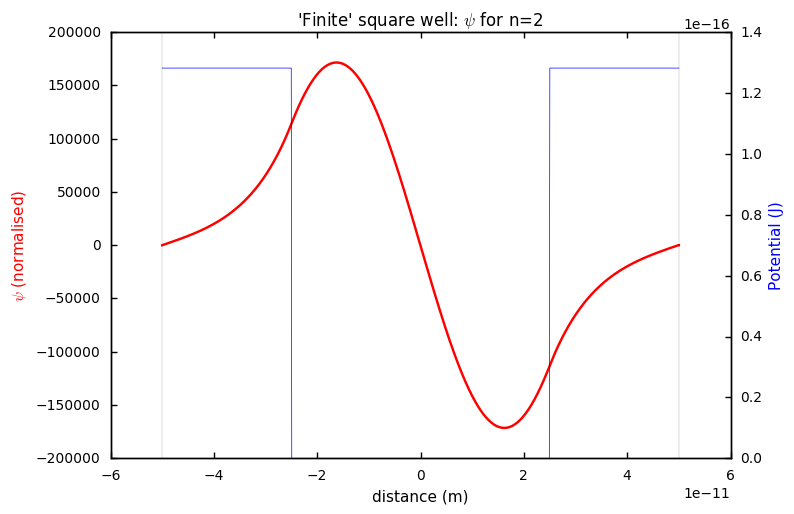

In [24]:
#SECANT METHOD:
E1 = 45*e
E2 = 250*e
psi2 = RungeKutta2d(E1)[-1]

tolerance = e/1000

while abs(E1-E2)>tolerance:
    psi1 = psi2
    psi2 = RungeKutta2d(E2)[-1]
    E1, E2 = E2, E2-psi2*(E2-E1)*np.power((psi2-psi1),-1)
    
print("Energy for n=2: ",E2,"J"," [",E2/e, "eV ]")

finiteenergy_2 = E2
finitewell_2 = psi_normalised(E2) #normalise psi


#PLOTTING: 

fig, ax1 = plt.subplots()

#PSI:
ax1.plot(xarray, finitewell_2, 'r')
ax1.set_xlabel('distance (m)')
ax1.set_ylabel('$\psi$ (normalised)', color='r')

#POTENTIAL:
ax2 = ax1.twinx()
ax2.plot(xarray, V_finite(xarray), 'b', lw=0.5)
ax2.set_ylabel('Potential (J)', color='b')

plt.axvline(x=-a,c='k',ls='-',lw=0.1)
plt.axvline(x=a, c='k',ls='-',lw=0.1)
plt.title("'Finite' square well: $\psi$ for n=2")
;

#### *n=3*

Energy for n=3:  1.19270674383e-16 J  [ 744.418139954 eV ]


''

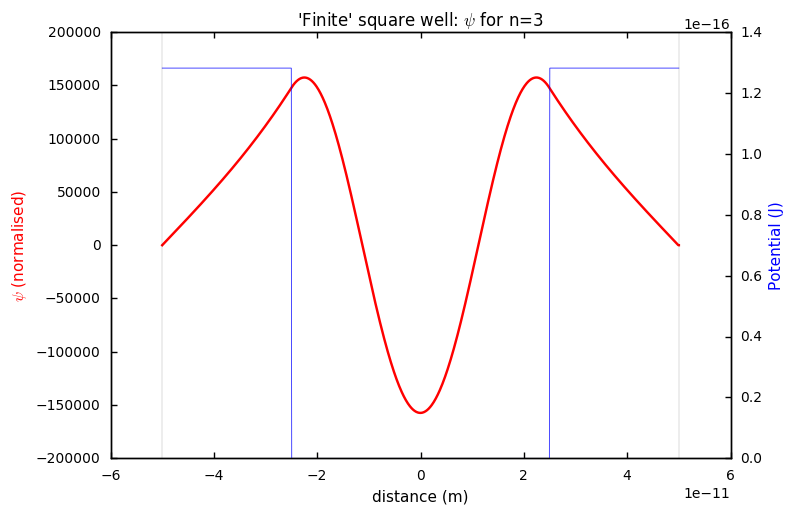

In [25]:
#SECANT METHOD:
E1 = 250*e
E2 = 550*e
psi2 = RungeKutta2d(E1)[-1]

tolerance = e/1000

while abs(E1-E2)>tolerance:
    psi1 = psi2
    psi2 = RungeKutta2d(E2)[-1]
    E1, E2 = E2, E2-psi2*(E2-E1)*np.power((psi2-psi1),-1)
    
print("Energy for n=3: ",E2,"J"," [",E2/e, "eV ]")

finiteenergy_3 = E2
finitewell_3 = psi_normalised(E2)


#PLOTTING:
fig, ax1 = plt.subplots()

#PSI:
ax1.plot(xarray, finitewell_3, 'r')
ax1.set_xlabel('distance (m)')
ax1.set_ylabel('$\psi$ (normalised)', color='r')

#POTENTIAL:
ax2 = ax1.twinx()
ax2.plot(xarray, V_finite(xarray), 'b', lw=0.5)
ax2.set_ylabel('Potential (J)', color='b')

plt.axvline(x=-a,c='k',ls='-',lw=0.1)
plt.axvline(x=a, c='k',ls='-',lw=0.1)
plt.title("'Finite' square well: $\psi$ for n=3")
;

''

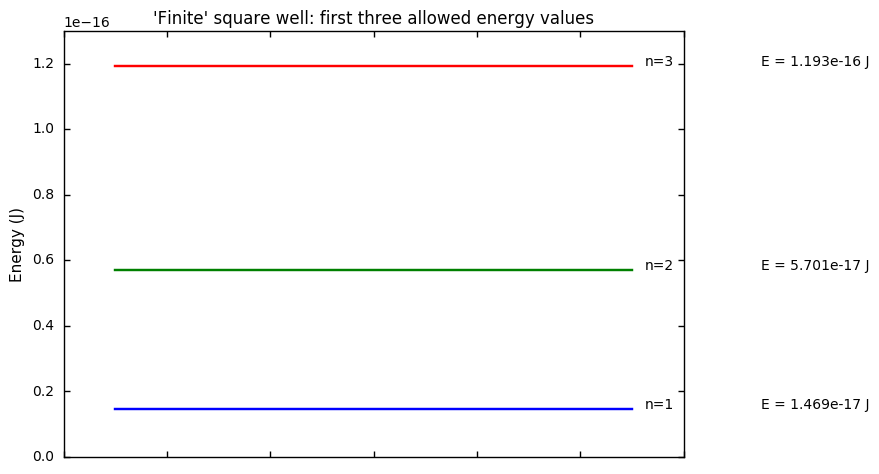

In [26]:
fig, ax1 = plt.subplots()

#plot eigenenergies:
ax1.plot(xarray, (xarray*0)+finiteenergy_1) #n=1
ax1.plot(xarray, (xarray*0)+finiteenergy_2) #n=2
ax1.plot(xarray, (xarray*0)+finiteenergy_3) #n=3

#Labelling:
ax1.text(1.05*a,finiteenergy_1,'n=1')
ax1.text(1.05*a,finiteenergy_2,'n=2')
ax1.text(1.05*a,finiteenergy_3,'n=3')
ax1.text(1.5*a,finiteenergy_1,'E = 1.469e-17 J')
ax1.text(1.5*a,finiteenergy_2,'E = 5.701e-17 J')
ax1.text(1.5*a,finiteenergy_3,'E = 1.193e-16 J')
plt.ylim(0,1.3e-16)


ax1.set_xticklabels([])
ax1.set_ylabel('Energy (J)')
plt.title("'Finite' square well: first three allowed energy values")
;

Looking at the $n=1,2,3$ plots, the numerical wavefunctions match what we would expect from the finite square well: $n+1$ nodes, the familiar sinusoidal shape within the well and an exponential decay in $\psi$ outside the well. As the FSW has no analytic solution, it's difficult to tell how good an approximation our result is. However, we can make some rough qualitative predictions about how our results *should* compare with the results from the ISW. 

From theory, we would expect the finite square well eigenvalues to be *lower* than the those of the infinite square well: as the FSW wavefunction extends from $-\infty$ to $+\infty$ rather than from $-a$ to $+a$, the wavelength of $\psi$ for each state is longer in the FSW than the ISW; this increase in wavelength manifests itself as a decrease in energy. As our FSW is half the width of our ISW, it's difficult to directly compare the eigenvalues of each to verify this prediction. However, we can use two facts to obtain a rough estimate of what the eigenvalues of the FSW should be:

&nbsp;

<div align="center">
*ISW eigenvalues vary inversely with the square of the well width.*
</div>

<div align="center">
*FSW eigenvalues are approximately 1.5 times smaller than the corresponding ISW eigenvalues [3]*
</div>

So each FSW eigenvalue should be *roughly* $\frac{2^2}{1.5} \approx 2.6$ times the corresponding ISW energy.

Comparing the eigenvales of the ISW and FSW, this fits with what we see:


$$E_{ground}^{ISW} = 37.6 eV$$ 

$$E_{ground}^{FSW} = 91.7 eV$$



$$E_{2}^{ISW} = 150.4 eV$$

$$E_{2}^{FSW} = 355.8 eV$$


$$E_{3}^{ISW} = 338.4 eV$$

$$E_{3}^{FSW} = 744.4 eV$$

Note that the $n=3$ state has an energy of $744.4$ $eV$, close to the well depth of $800$ $eV$. This is another way in which the ISW and FSW differ: the finite square well has a finite number of allowed energy states, in this case 3.

#### 4.2 Free particles and unbound states

We can also analyse the behaviour of a particle with an energy greater than the depth of the well. As the allowed energies of a free particle form a continuum, we don't need to use the secant method to find particular allowed states. Setting the particle energy, `Efree` to $1400$ $eV$ (i.e. 1.75 times the well depth), we can then pass this value directly to the Runge-Kutta function to calculate the wavefunction.

''

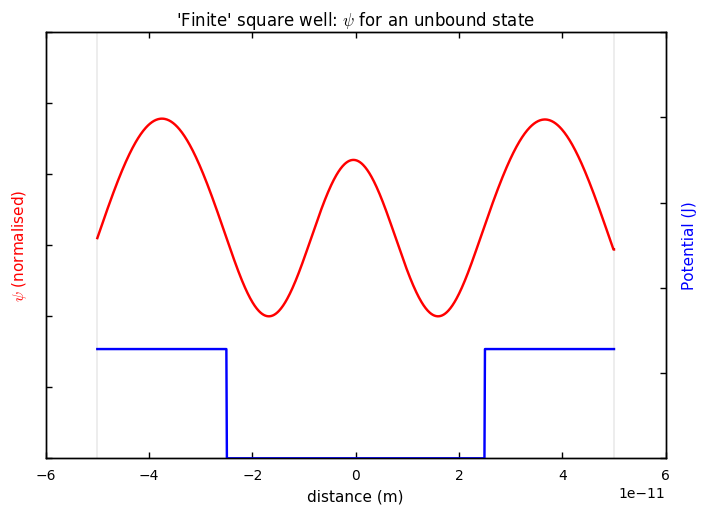

In [27]:
Efree = 1.75*v0  #set the particle energy to 1.75x the height of the well 
finitewell_free = psi_normalised(Efree) #normalise psi

#PLOTTING: 

fig, ax1 = plt.subplots()

#Psi:
ax1.plot(xarray, (finitewell_free)+10000, 'r')
ax1.set_xlabel('distance (m)')
ax1.set_ylabel('$\psi$ (normalised)', color='r')
ax1.set_yticklabels([])
plt.title("'Finite' square well: $\psi$ for an unbound state")
plt.ylim(-300000,300000)

#Potential:
ax2 = ax1.twinx()
ax2.plot(xarray, V_finite(xarray), 'b')
ax2.set_ylabel('Potential (J)', color='b')
ax2.set_yticklabels([])

plt.ylim(0,5*10**-16)
plt.axvline(x=-a,c='k',ls='-',lw=0.1)
plt.axvline(x=a, c='k',ls='-',lw=0.1)
;

As expected, $\psi$ is completely sinusoidal, with none of the exponential decay in amplitude seen in the wavefunctions of the bound states. As the particle energy is greater than the depth of the well, the particle can be found with *roughly* equal likelihood in any region of the system. However, there is a small discrepancy here: in the regions where $V(x) > 0$, the amplitude of the wavefunction (and therefore the probability of finding the particle) is slightly larger. 

This effect can be understood from a semi-classical perspective: consider a particle with constant energy $H$, where

$$
H = E_{kinetic} + E_{potential}
$$

When the particle moves into a region of higher potential, its kinetic energy is necessarily reduced. As the particle moves with reduced speed, it spends longer in the region of higher potential, thus making it more likely to be found in this region. This leads to the increase in the amplitude of $\psi$ in regions of non-zero potential seen in the plot above.

## 5.0 The double well

By changing our potential function, we can model any system based on the infinite square well. One potential that is often seen in atomic physics is the *double well* (see Fig. 4.), consisting of two finite potential wells separated by a barrier of height $V_0$ and width $0.4a$. Physically, this can be used to model a system with two *degenerate* ground states, both of energy $0$.

![](http://i.imgur.com/jd7iVdA.png)

#### *Fig. 4. The double well potential*

Source: Created by the Author

Such systems are frequently encountered in molecular physics. Benzene, for example, has two degenerate ground states  in superposition with one other [4] (see Fig. 5). Though the potential of a system like benzene is significantly more complex than a simple double well, we can nevertheless use the simplified model to make some basic qualitative predictions.

![](https://i.stack.imgur.com/9tig3.png)

#### Fig. 5. The two ground states of Benzene. Each inner line represents the position of a double bond (i.e. a pair of electrons).
Source: https://en.wikipedia.org/wiki/Benzene

To create the double well potential function, we re-use the function we used for the finite single square well, creating a square wave with period $0.75a$. We'll keep the well depth at $800 eV$.

In [28]:
v0 = 800*e #define v0

def V_double(x):
    '''Calculates the simple harmonic potential from input x (position)'''
    #Creates a a square wave w/ half the previous wavelength (to create a double well).
    return v0*0.5*(np.sign(-np.sin(np.pi*((x/(0.4*a))+1.5)))+1)

In [29]:
def f(r,x,E): 
    '''Schrödinger equation for a particle in a potential V.
    Inputs are r (phi and psi), x (position), and E'''
    psi = r[0]  #first element of r is psi
    phi = r[1] #second element of r is psi
    fpsi = phi  #derivative of psi = phi
    fphi = 2*m*(h_bar**(-2))*(V_double(x)-E)*psi #derivative of phi = rhs of schrödinger eqn
    return np.array([fpsi,fphi]) #return fpsi and fphi as array

We can then plot the $n=1$ state:

Energy for n=1:  4.6917566994e-17 J  [ 292.832149507 eV ]


''

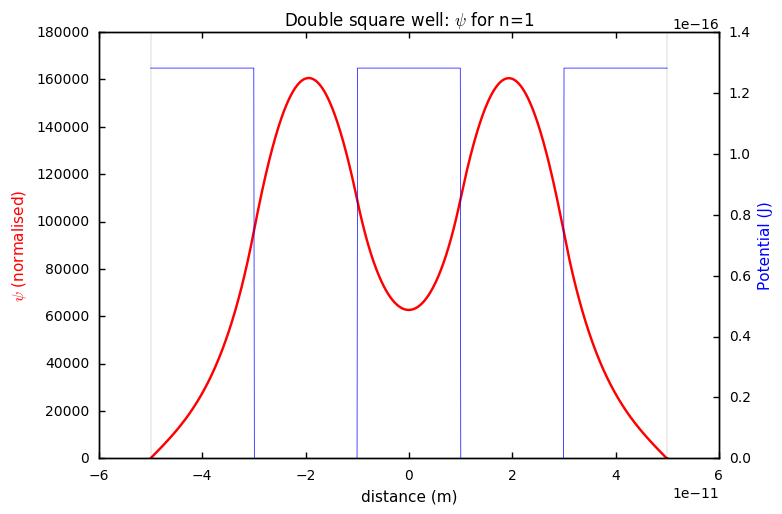

In [30]:
#SECANT METHOD:
E1 = 0*e
E2 = 45*e
psi2 = RungeKutta2d(E1)[-1]

tolerance = e/1000

while abs(E1-E2)>tolerance:
    psi1 = psi2
    psi2 = RungeKutta2d(E2)[-1]
    E1, E2 = E2, E2-psi2*(E2-E1)*np.power((psi2-psi1),-1)
    
print("Energy for n=1: ",E2,"J"," [",E2/e, "eV ]")
doublewell_1 = psi_normalised(E2) #normalise psi

#PLOTTING: 

fig, ax1 = plt.subplots()

#PSI:
ax1.plot(xarray, doublewell_1, 'r')
ax1.set_xlabel('distance (m)')
ax1.set_ylabel('$\psi$ (normalised)', color='r')

#POTENTIAL:
ax2 = ax1.twinx()
ax2.plot(xarray, V_double(xarray), 'b', lw=0.5)
ax2.set_ylabel('Potential (J)', color='b')

plt.axvline(x=-a,c='k',ls='-',lw=0.1)
plt.axvline(x=a, c='k',ls='-',lw=0.1)
plt.title("Double square well: $\psi$ for n=1")
;

This can be interpreted as two ground state FSW wavefunctions in superposition, with each well separated by $0.4Å$ (for reference, this is the same order of magnitude as the seperation between atoms in an $H_2$ molecule [5]). The particle has an equal likelihood of being found in either potential well, whilst also having a significant chance of being found in neither (i.e. the classicaly forbidden region).

As expected, $\psi(x)$ drops off exponentially to $0$ in the region $|x|> 0.3Å$, consistent with the requirement that the wavefunction be continuous. An interesting feature is the hyperbolic nature of the wavefunction in the central potential barrier (from $-1Å$ to $+1Å$), which can be considered the superposition of the wavefunctions from two separate finite square wells, where $A$ and $k$ are constants:

$$
\psi_{left} = Ae^{-kx}
$$
$$
\psi_{right} = Ae^{ kx}
$$

Taking the sum of these two wavefunctions produces:

$$
\psi = Ae^{-kx} + Ae^{ kx}
$$
$$
\psi = A'cosh(kx)
$$

This is valid because the Schrōdinger equation is a *linear* second order ODE, meaning that the sum of two solutions is also a solution. This alows us to consider the $n=1$ double-well wavefunction as a linear combination of two individual FSW wavefunctions.

#### 5.2 The first excited state of the double well

Energy for n=2:  5.29167616713e-17 J  [ 330.275631452 eV ]


''

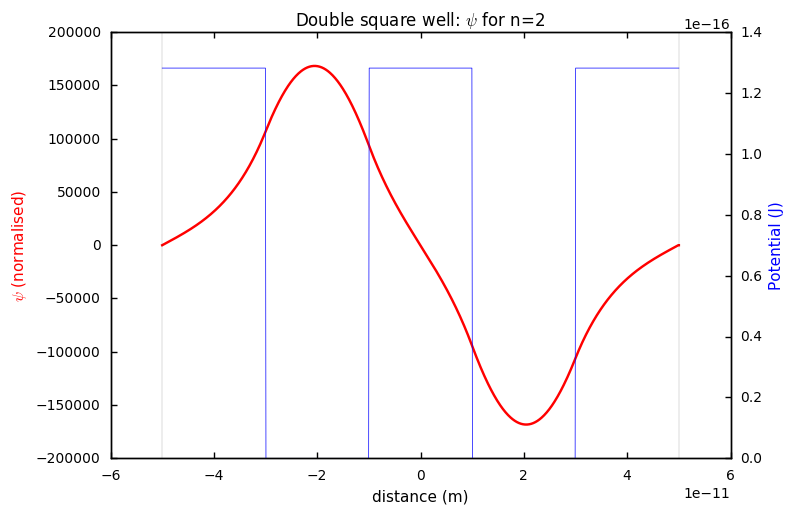

In [31]:
#SECANT METHOD:
E1 = 45*e
E2 = 350*e
psi2 = RungeKutta2d(E1)[-1]

tolerance = e/1000

while abs(E1-E2)>tolerance:
    psi1 = psi2
    psi2 = RungeKutta2d(E2)[-1]
    E1, E2 = E2, E2-psi2*(E2-E1)*np.power((psi2-psi1),-1)
    
print("Energy for n=2: ",E2,"J"," [",E2/e, "eV ]")
doublewell_1 = psi_normalised(E2) #normalise psi

#PLOTTING: 

fig, ax1 = plt.subplots()

#PSI:
ax1.plot(xarray, doublewell_1, 'r')
ax1.set_xlabel('distance (m)')
ax1.set_ylabel('$\psi$ (normalised)', color='r')

#POTENTIAL:
ax2 = ax1.twinx()
ax2.plot(xarray, V_double(xarray), 'b', lw=0.5)
ax2.set_ylabel('Potential (J)', color='b')

plt.axvline(x=-a,c='k',ls='-',lw=0.1)
plt.axvline(x=a, c='k',ls='-',lw=0.1)
plt.title("Double square well: $\psi$ for n=2")
;

Plotting the first excited state reveals a number of interesting properties of the double well. Firstly, the energy of the state isn't as large as one might expect it to be in comparison with the ground state energy, with $E_{n=2}$ only 13% larger than $E_{ground}$. The second interesting feature is the shape of the wavefunction: from $-a$ to $0$, $\psi_{n=2}$ behaves similarly to the ground state wavefunction, before passing through the origin at $x=0$ and flipping in the x-axis.

In molecular physics, this state is known as the *antibonding* state. If we take the two potential wells to represent two hydrogen atoms in an $H_2$ molecule, we can see that in the $n=1$ state there is a much higher likelihood of finding the electron between the two atoms (in the central potential barrier) than in the $n=2$ state. Indeed, the chance of finding the electron exactly between the two atoms in the $n=2$ state is $0$, as the wavefunction passes through the x-axis at the point directly between the two wells. This causes the antibonding state to have a slightly higher energy than the bonding (i.e. ground) state, as the electron has a lower probability of being found between the two atoms [6]. 

This energy shift can also be understood in terms of the uncertainty principle. Compared to the $n=1$ state, the electron in the $n=2$ state is subject to a greater degree of spatial confinement, as it has a lower probability density between the two potential wells. This reduction in positional uncertainty is accompanied by an increase in the uncertainty of the electron momentum, and therefore kinetic energy.

## 6. Discussion

Whilst the technique of modifying the ISW base to simulate various different potentials provided excellent descriptions of the wavefunction from a qualitative perspective, it was of limited use in providing accurate quantitative data for any system other than the infinite square well.

For all four systems looked at, the eigenstates were accurately reproduced: wavefunctions matched what was expected in each potential well, with smooth sinusoidal curves and exponential decay in the classically forbidden region. More complex wavefunction behaviour was also accurately modelled, such as the linear superposition of two exponentially decaying wavefunctions into one hyperbolic eigenstate in the double well. 

The method also produced eigenvalues that behaved as predicted: in the ISW, the spacing between each energy level increased as a function of $n^2$, whilst in the quantum harmonic oscillator they were equally spaced. The almost-degenerate first two energy levels of the double well were also reproduced as expected. However, whilst the relations between the eigenvalues were highly accurate, the numerical values of the eigenvalues themselves were less so. This had less to do with the fundamental limitations of the method and more to do with the parameters used - specifically $a$, the distance from the origin to the region of infinite potential. In the FSW, $a$ was the same as the well width, too small a distance to model tunnelling behaviour to a high degree of accuracy. Ideally, $a$ would be as close to $\infty$ as possible - obviously this is computationally impractical, but a value of 3 or 4 times the well width should be enough to find eigenvalues accurate to a few decimal places. An interesting future exercise might involve comparing these eigenvalues to the energies calculated using an alternative numerical method.

Another useful future exercise might involve changing the parameters of the double well such that it models the $H_2$ molecule (e.g. adjusting the well separation to the bond length of $H_2$ and changing the height of the central potential barrier). The calculated energies of the bonding and antibonding states could then be compared with empirically-derived data to evaluate the accuracy of the model.



## Bibliography

[1]	S. Carroll, "Why probability in quantum mechanics is given by the wave function squared," in Preposterous Universe, 2014. [Online]. Available: http://www.preposterousuniverse.com/blog/2014/07/24/why-probability-in-quantum-mechanics-is-given-by-the-wave-function-squared/. Accessed: Feb. 27, 2017.

[2] W. H. Press, B. P. Flannery, S. A. Teukolsky, and W. T. Vetterling, Numerical recipes in C: The art of scientific computing, 2nd ed. Cambridge: Cambridge University Press, 1992.

[3] Hyperphysics. [Online]. Available: http://hyperphysics.phy-astr.gsu.edu/hbase/quantum/pbox.html. Accessed: Mar. 6, 2017.

[4] 	"University of Colorado, Boulder,". [Online]. Available: http://www.colorado.edu/physics/phys5250/phys5250_fa14/lecnotes.2014-09-26.Ammonia_Inversion.html. Accessed: Mar. 6, 2017.

[5] C. Yoder, "Wired Chemist," 2017. [Online]. Available: http://www.wiredchemist.com/chemistry/data/bond_energies_lengths.html. Accessed: Mar. 6, 2017.

[6] P. W. Atkins, J. de Paula, U. J. de Paula, and J. Depaula, Atkins’ physical chemistry, 8th ed. New York: W.H. Freeman & Company, 2006.